In [1]:
import numpy as np 
paras = np.load('pi_result_60_paras.npy',allow_pickle=True)[0]
results = np.load('pi_result_60_results.npy',allow_pickle=True)[0]

In [2]:
#transmon anharmonicity
k_q = -200e-3 * 2*np.pi  
#transmon truncation level
N_q = 5
#duration
total_time = 60
#number of time intervals for AWG
total_time_steps=2*total_time
#target
angle= np.pi
#range of δ you care
fluc=np.arange(-10,10)*2*np.pi*1e-3

5.154193497836079e-06
[-2 -2 -6] 244
5.927063003036137e-06
[ 8 -8  0] 591


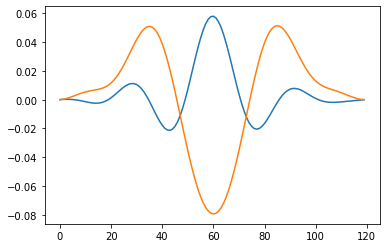

In [3]:
import matplotlib.pyplot as plt
#cost_function threshold
c_t = 6e-6
for i in range(len(results)):
    if results[i].best_error/8 <c_t :
        print(results[i].best_error/8 )
        print(paras[i],i )# print index for the pulse
        plt.plot(results[i].best_controls[0]/2/np.pi) 

In [4]:
pulse_index = 244

# Plot pulse bandwidth

(-0.25, 0.25)

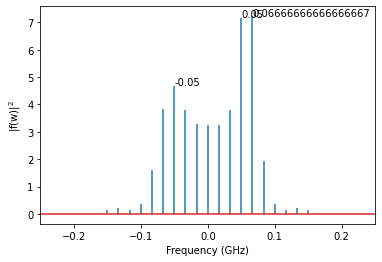

In [5]:
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
from numpy.fft import fft,fftfreq,ifft
fourier = np.abs(fft(results[pulse_index].best_controls[0]-1j*results[pulse_index].best_controls[1]))
freq = fftfreq(len(times), times[1]-times[0])
max_index = np.argpartition(abs(fourier), -3)[-3:]
fig,ax=plt.subplots()
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('|f(w)|$^2$')
ax.stem(freq, fourier, markerfmt=' ', label='')
for index in max_index:
    ax.annotate('{}'.format(freq[index]), xy=(freq[index], fourier[index]))
ax.set_xlim(-0.25,0.25)

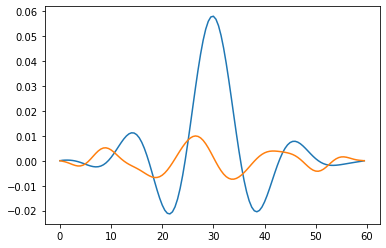

In [6]:
plt.plot(times,results[pulse_index].best_controls[0]/2/np.pi)
plt.plot(times,results[pulse_index].best_controls[1]/2/np.pi)

# Check infidelity v.s detuning by qutip

In [9]:

pulse=results[pulse_index].best_controls
# Qutip will do interpolation for drive, which distort piece-wise-constant control. 
# Here I manually do interpolation to make sure piece-wise-constant pulse.
resolution = 10
times = np.linspace(0, total_time, total_time_steps*resolution+1)
times=np.delete(times, [len(times) - 1])
osc_control=np.array([np.cos(2*np.pi*5*times),np.sin(2*np.pi*5*times)])
best_controls=np.zeros_like(osc_control)
for m in range(len(best_controls)):
    for i in range(len(pulse[0])): 
        for j in range(resolution):
            best_controls[m][i*resolution+j]=pulse[m][i]*(1)

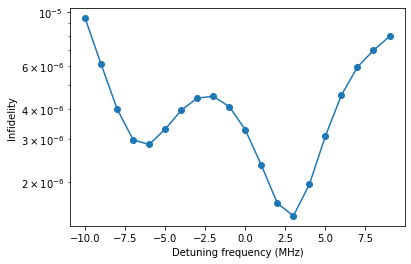

In [8]:
def dev_gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    return (- amp * (t-ti-tg/2)/(sigma**2) * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) ) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)
def gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    offset = amp * np.exp(-(tg/2)**2/(2*sigma**2))
    return (amp * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) - offset) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
import qutip as qt
from qutip import *
import scipy.special as sp
target_states=np.zeros([N_q,N_q],dtype=complex)
target_states=Rx(target_states,angle)
a_q = destroy(N_q)
n_q = a_q.dag() * a_q
x_q = a_q + a_q.dag()
cross = 0e-3 * 2*np.pi
# without -1/2, strange result when change time origin
H0 =  1/2*k_q * a_q.dag()**2 * a_q**2
Hcx=a_q+a_q.dag()
Hcy=-a_q*1j+1j*a_q.dag()
H0=H0.data.toarray()
Hcx=Hcx.data.toarray()
Hcy=Hcy.data.toarray()
H_controls=[Hcx,Hcy]
U_ideal=qt.Qobj(target_states)
#infidelity withought fluctuation
import qutip as qt
options = qt.Options(rtol=1e-10, atol=1e-10)
qt_H0=qt.Qobj(H0)

qt_Hcx=qt.Qobj(H_controls[0])
qt_Hcy=qt.Qobj(H_controls[1])
qt_tlist=times

fluc_oper=n_q
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
options = qt.Options(rtol=1e-10, atol=1e-10)
U_ideal=qt.Qobj(target_states)
x=np.pi/angle
for i in range(len(fluc)):
    qt_H0=qt.Qobj(H0+fluc[i]*fluc_oper)
    qt_tlist=times
    qt_cx = best_controls[0]
    qt_cy = best_controls[1]
    qt_H=[qt_H0,[qt_Hcx,qt_cx],[qt_Hcy,qt_cy]]
    output = qt.propagator(qt_H, qt_tlist, options=options)
    infidelities[i]=1-np.abs(np.trace((U_ideal*output[-1].dag())))**2/4
fig,ax=plt.subplots()
ax.plot(fluc/(2*np.pi)*1e3,infidelities)
ax.set_xlabel('Detuning frequency (MHz)')
ax.set_ylabel('Infidelity')
ax.scatter(fluc/(2*np.pi)*1e3,infidelities)
ax.set_yscale('log')